# Interpretation of Pumping Tests

During a constant flow pumping test, the values of drawdown as a function of time are detected in a piezometer placed at a distance r from the well, which withdraws water from the aquifer at a constant flow rate Q. Calculate the values of the transmissivity T and of the storage coefficient S with the Theis and Jacob method.

Theis law:
$$
s(r,t) = \frac{Q}{4 \pi T} W(\eta); \quad
\eta = \frac{S r^2}{4 T t}; \quad
W(\eta) = \int_\eta^\infty \tau^{-1}e^{-\tau} \, d\tau
$$

$S$: $[1]$ 

$T$: $[\frac{\text{length}^2}{\text{time}}]$ 

In [2]:
#import essential libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#parameter to use Latex in matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#a plot label should be easy to read
plt.rcParams.update({'font.size': 14})
from scipy.special import exp1 as expintegral
import emcee

## First Well (confined acquifer)

In [3]:
#Import data for well number 1 (confined acquifer)
flowrate = 5430 / 24 / 60 #m3/min 
r =	30.5 #m

times = np.array([1,2,3,4,5,6,7,10,20,40,80,100,300,500,1000]) #minutes
drawdowns = np.array([1.2,1.6,1.9,2.1,2.3,2.5,2.7,3.1,3.7,4.3,4.8,5,5.8,6.2,6.6]) #meters

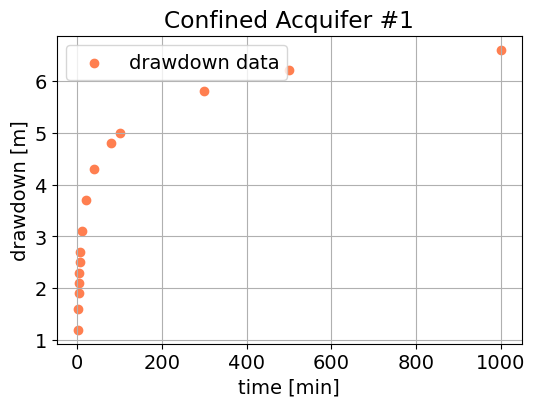

In [8]:
#VIsualize Data
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(times,drawdowns, color= "coral", label="drawdown data")

plt.xlabel('time [min]')
plt.ylabel(r"drawdown [m]")
plt.grid(True)
plt.title("Confined Acquifer #1")
plt.legend()
plt.show()

Let's perform a fit (bayesian fit w/ mcmc) to estimate S and T and verify Theis' model: we will sample the pdf of the parameters given the data, Theis' model and a chi-square probabilistic model

  0%|          | 0/5000 [00:00<?, ?it/s]/home/lorenzo/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:20<00:00, 241.77it/s]


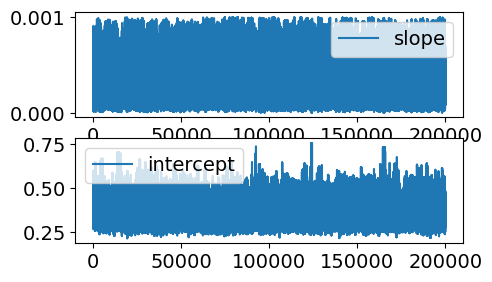

In [5]:
# Define the model
def Theis(params, x):
    storage, transmissivity = params
    etas = storage * r**2 / 4 / transmissivity / x
    return flowrate / 4 / np.pi / transmissivity * expintegral(etas, out=None)

# Define the log-likelihood function
def log_likelihood(params, x, y):
    y_pred = Theis(params, x)
    residuals = y - y_pred
    chi_squared = np.sum((residuals)**2)
    return -0.5 * chi_squared

# Define the log-prior function
def log_prior(params):
    storage, transmissivity = params
    if 0.00001 < storage < 0.001 and 0.05 < transmissivity < 1.5 :
        return 0.0
    return -np.inf

# Define the log-posterior function
def log_posterior(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)

# Set up the MCMC sampler
nwalkers = 50
ndim = 2  # Number of parameters in the model
initial_guess = [0.0001,0.5]  # Initial guess for parameters

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(times, drawdowns))

# Run the MCMC sampler
n_steps = 5000
sampler.run_mcmc(initial_guess + 0.0001 * np.random.randn(nwalkers, ndim), n_steps, progress=True)

# Extract the samples from the chain
samples = sampler.get_chain(discard=1000,flat=True)

# Plot the results
plt.figure(figsize=(5, 3))
plt.subplot(2, 1, 1)
plt.plot(samples[:, 0], label='slope')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(samples[:, 1], label='intercept')
plt.legend()
plt.show()

(13300, 2)


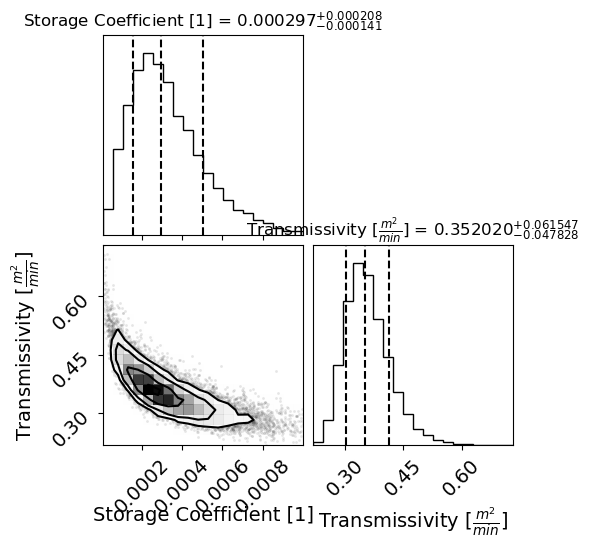

In [12]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

import corner
figure = corner.corner(
    flat_samples,
    labels=[
        r"Storage Coefficient [1]",
        r"Transmissivity [$\frac{m^2}{min}$]",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".6f",
    title_kwargs={"fontsize": 12},
)
plt.show()


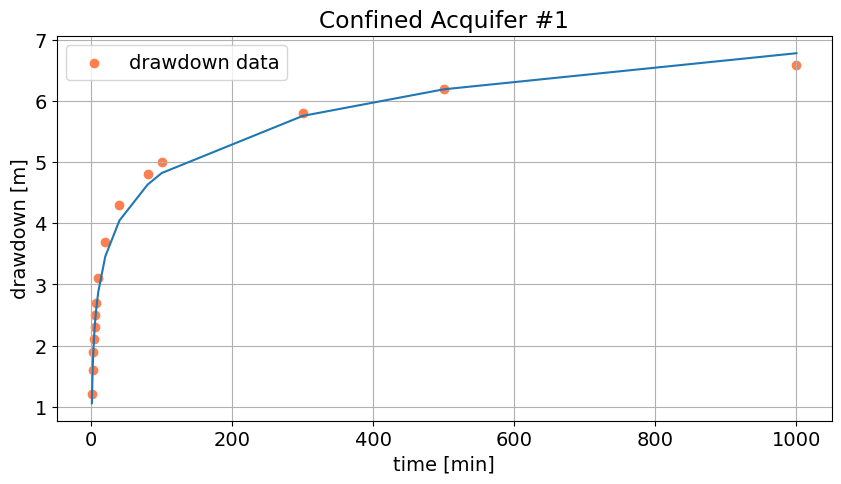

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(times,drawdowns, color= "coral", label="drawdown data")
params = [0.000297,0.352]
ax.plot(times, Theis(params,times))
plt.xlabel('time [min]')
plt.ylabel(r"drawdown [m]")
plt.grid(True)
plt.title("Confined Acquifer #1")
plt.legend()
plt.show()

## Second well (confined acq)

In [71]:
#Import data for well number 2 (confined acquifer)
flowrate = 220 * 6.31 * 1e-5 *60 #m3/min 
r =	824 * 0.3048 #m

times = np.array([3,5,8,12,20,24,30,38,47,50,60,70,80,90,100,130,160,200,260,320,380,500]) #minutes
drawdowns = np.array([0.3,0.7,1.3,2.1,3.2,3.6,4.1,4.7,5.1,5.3,5.7,6.1,6.3,6.7,7,7.5,8.3,8.5,9.2,9.7,10.2,10.9]) #feet
drawdowns = drawdowns * 0.3048 #meters

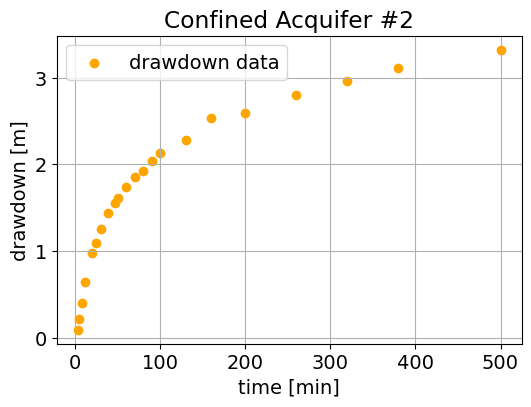

In [72]:
#VIsualize Data
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(times,drawdowns, color= "orange", label="drawdown data")

plt.xlabel('time [min]')
plt.ylabel(r"drawdown [m]")
plt.grid(True)
plt.title("Confined Acquifer #2")
plt.legend()
plt.show()

  0%|          | 15/5000 [00:00<00:33, 147.97it/s]

100%|██████████| 5000/5000 [00:12<00:00, 402.62it/s]


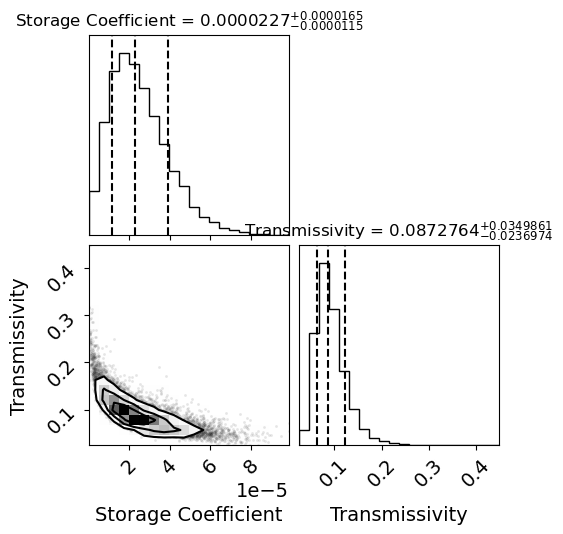

In [80]:
# Redefine the function to fit
# Define the model
def Theis(params, x):
    storage, transmissivity = params
    etas = storage * r**2 / 4 / transmissivity / x
    return flowrate / 4 / np.pi / transmissivity * expintegral(etas, out=None)

# Define the log-likelihood function
def log_likelihood(params, x, y):
    y_pred = Theis(params, x)
    residuals = y - y_pred
    chi_squared = np.sum((residuals)**2)
    return -0.5 * chi_squared

# Define the log-prior function
def log_prior(params):
    storage, transmissivity = params
    if 0.00000001 < storage < 0.0001  and 0.0005 < transmissivity < 1.5  :
        return 0.0
    return -np.inf

# Define the log-posterior function
def log_posterior(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)

# Set up the MCMC sampler
nwalkers = 50
ndim = 2  # Number of parameters in the model
initial_guess = [0.0000297, 0.22]  # Initial guess for parameters

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(times, drawdowns))

# Run the MCMC sampler
n_steps = 5000
sampler.run_mcmc(initial_guess + 0.0000001 * np.random.randn(nwalkers, ndim), n_steps, progress=True)

flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

figure = corner.corner(
    flat_samples,
    labels=[
        r"Storage Coefficient",
        r"Transmissivity",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".7f",
    title_kwargs={"fontsize": 12},
)
plt.show()

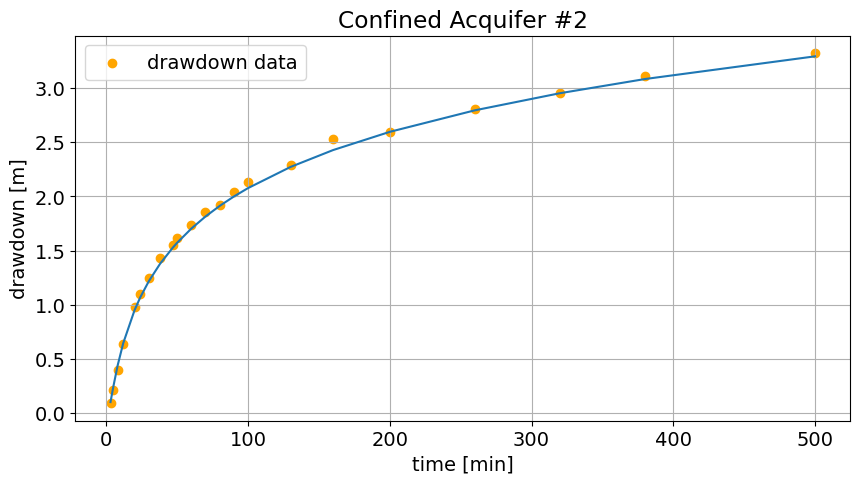

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(times,drawdowns, color= "orange", label="drawdown data")
params = [0.0000215, 0.086]
ax.plot(times, Theis(params,times))
plt.xlabel('time [min]')
plt.ylabel(r"drawdown [m]")
plt.grid(True)
plt.title("Confined Acquifer #2")
plt.legend()
plt.show()

## Third well (confined acq)

In [85]:
#Import data for well number 2 (confined acquifer)
flowrate = 1500 /24 /60 #m3/min 
r =	100 #m

times = np.array([2,2.5,3,4,5,6,7,8,10,15,20,25,30,40,50,65,80,100,200,300,400,500]) #minutes
drawdowns = np.array([0.100,0.137,0.183,0.274,0.335,0.396,0.488,0.579,0.625,0.792,1.036,1.189,1.250,1.463,1.646,1.829,1.951,2.103,2.606,2.957,3.109,3.261]) #meters

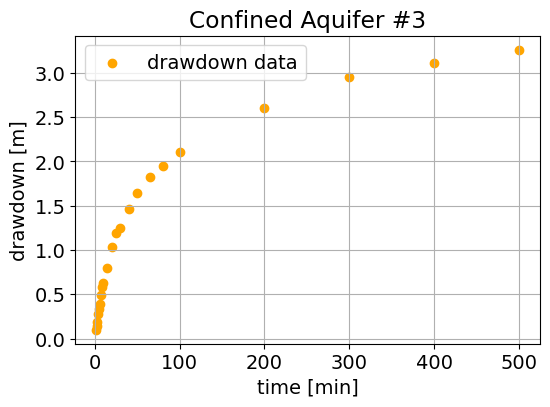

In [100]:
#VIsualize Data
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(times,drawdowns, color= "orange", label="drawdown data")

plt.xlabel('time [min]')
plt.ylabel(r"drawdown [m]")
plt.grid(True)
plt.title("Confined Aquifer #3")
plt.legend()
plt.show()

  0%|          | 17/5000 [00:00<00:30, 163.98it/s]

100%|██████████| 5000/5000 [00:14<00:00, 347.49it/s]


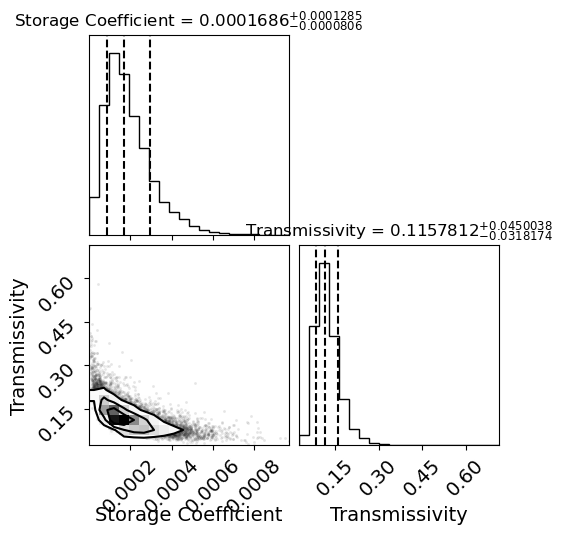

In [89]:
# Redefine the function to fit
# Define the model
def Theis(params, x):
    storage, transmissivity = params
    etas = storage * r**2 / 4 / transmissivity / x
    return flowrate / 4 / np.pi / transmissivity * expintegral(etas, out=None)

# Define the log-likelihood function
def log_likelihood(params, x, y):
    y_pred = Theis(params, x)
    residuals = y - y_pred
    chi_squared = np.sum((residuals)**2)
    return -0.5 * chi_squared

# Define the log-prior function
def log_prior(params):
    storage, transmissivity = params
    if 0.00000001 < storage < 0.001  and 0.0005 < transmissivity < 1.5  :
        return 0.0
    return -np.inf

# Define the log-posterior function
def log_posterior(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)

# Set up the MCMC sampler
nwalkers = 50
ndim = 2  # Number of parameters in the model
initial_guess = [0.000297, 0.22]  # Initial guess for parameters

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(times, drawdowns))

# Run the MCMC sampler
n_steps = 5000
sampler.run_mcmc(initial_guess + 0.0000001 * np.random.randn(nwalkers, ndim), n_steps, progress=True)

flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

figure = corner.corner(
    flat_samples,
    labels=[
        r"Storage Coefficient",
        r"Transmissivity",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".7f",
    title_kwargs={"fontsize": 12},
)
plt.show()

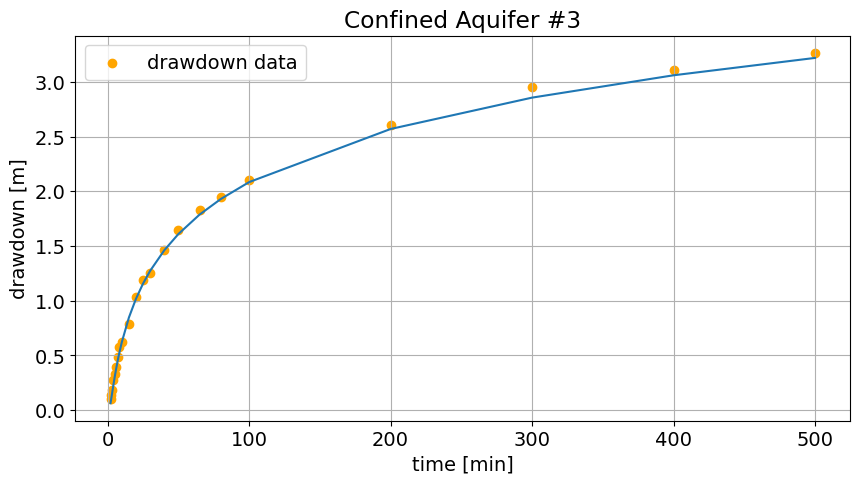

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(times,drawdowns, color= "orange", label="drawdown data")
params = [0.000146, 0.1158]
ax.plot(times, Theis(params,times))
plt.xlabel('time [min]')
plt.ylabel(r"drawdown [m]")
plt.grid(True)
plt.title("Confined Aquifer #3")
plt.legend()
plt.show()

### Results Summary
| aquifer | storage coefficient $S [\,]$| transmissivity $T [m^2/s] $|
|- |- |- |
| confined 1 | $2.97 \times 10^-4$ | $5.87 \times 10^-3$ | #[0.000297,0.352]
| confined 2 | $2.15 \times 10^-5$ | $1.43 \times 10^-3$ | [0.0000215, 0.086]
| confined 3 | $1.46 \times 10^-4$ | $1.93 \times 10^-3$ | [0.000146, 0.1158]

For the sake of curiosity, assuming the aquifer to be 10-100m thick and uniform along the vertical axis, from the trasnmissivity we could very crudely say that the acquifers consist on fine gravel ($\log_{10}K \in [-4,-1]$), sand ($\log_{10}K \in [-6,-3]$) or permeable silt (($\log_{10}K \in [-8,-5]$))

## Phreatic aquifer 1
Sheet“Phreatic aquifer 1”of file PumpingTests.xls lists the data measured during a pumping test in a phreatic aquifer. In particular, the drawdown in the well and in five piezometers are given. Assuming that T can be approximated as independent of h, estimate T and S with Theis’ method. Discuss the conditions under which the above mentioned assumption is satisfied.

In [167]:
#Import data for well number 2 (confined acquifer)
flowrate = 52 /1000 *60 #m3/min 
rs =	np.array([0.2 ,5,10	,20	,40	,60]) #meters <- assuming data in the excel was flipped (pz1 and pz2)

data = np.loadtxt('phreatic1.txt', skiprows=1)

In [168]:
times = data[:,0] #min
well = data[:,1]
PZ1 = data[:,2]
PZ2 = data[:,3]
PZ3 = data[:,4]
PZ4 = data[:,5]
PZ5 = data[:,6]

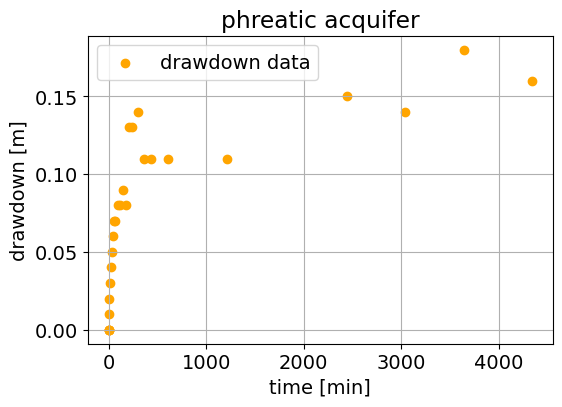

In [169]:
#VIsualize Data
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(times,PZ5, color= "orange", label="drawdown data")

plt.xlabel('time [min]')
plt.ylabel(r"drawdown [m]")
plt.grid(True)
plt.title("phreatic acquifer")
plt.legend()
plt.show()

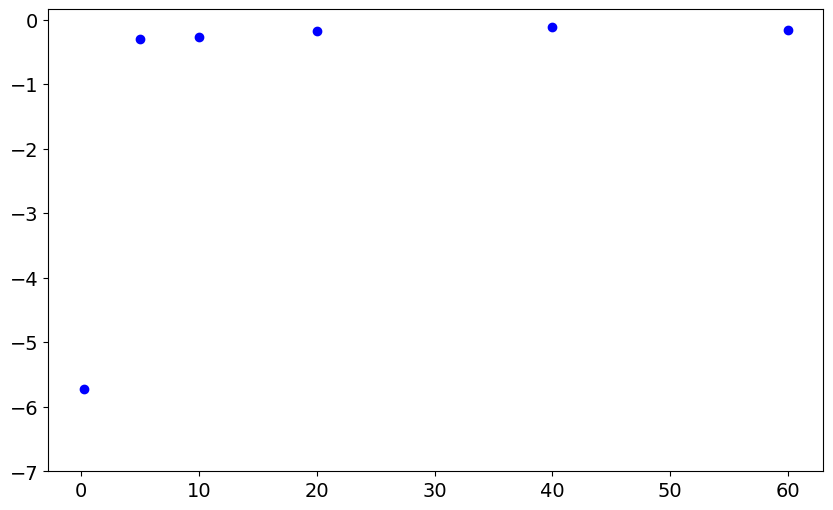

In [163]:
from matplotlib.animation import FuncAnimation

# Create some sample data
x = rs

nframes = len(well)

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.xticks(range(0, 70, 10))  
plt.yticks(range(-7, 0, 1))  



# Function to update scatter plots for each frame
def update(frame):
    ax.clear()
    
    # Create a new scatterplot for the current frame
    y = -data[frame,1:]
    sc = ax.scatter(x, y, c='blue', marker='o', label=f'Time {times[frame]}')
    plt.xticks(range(0, 70, 10))  
    plt.yticks(range(-7, 1, 1)) 

    return sc

# Create an animation
animation = FuncAnimation(fig, update, frames=nframes, interval=200)

# Display the animation
animation.save("anim.gif")
plt.show()

In [170]:
# Build data to find the most likely S and T from all the piezometers:
agg_drawdowns = np.concatenate((well[1:], PZ1[1:],  PZ2[1:], PZ3[1:], PZ4[1:], PZ5[1:])) #meters
# t -> t/r^2 : 
agg_times = np.concatenate((times[1:] / rs[0]**2, times[1:] / rs[1]**2, 
                            times[1:] / rs[2]**2, times[1:] / rs[3]**2,
                            times[1:] / rs[3]**2, times[1:] / rs[5]**2, ))

100%|██████████| 5000/5000 [00:26<00:00, 189.50it/s]


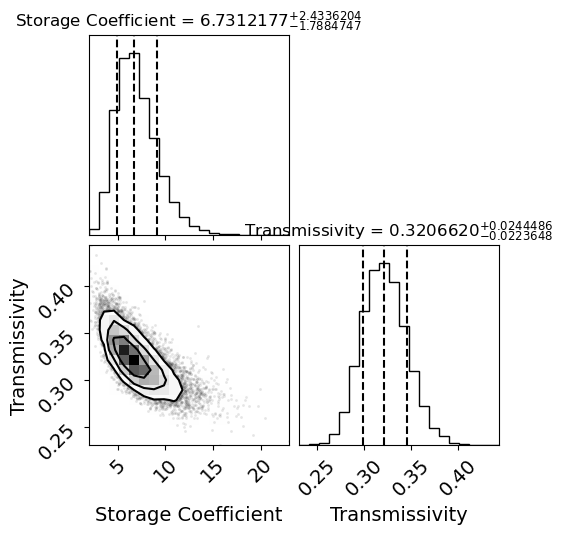

In [193]:
# Redefine the function to fit
# Define the model
def Theis2(params, x):
    storage, transmissivity = params
    etas = storage / 4 / transmissivity / x
    return flowrate / 4 / np.pi / transmissivity * expintegral(etas, out=None)

# Define the log-likelihood function
def log_likelihood(params, x, y):
    y_pred = Theis2(params, x)
    residuals = y - y_pred
    chi_squared = np.sum((residuals)**2)
    return -0.5 * chi_squared

# Define the log-prior function
def log_prior(params):
    storage, transmissivity = params
    if 0.00000001 < storage <100  and 0.000005 < transmissivity < 1.5  :
        return 0.0
    return -np.inf

# Define the log-posterior function
def log_posterior(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)

# Set up the MCMC sampler
nwalkers = 50
ndim = 2  # Number of parameters in the model
initial_guess = [0.000674,0.32]  # Initial guess for parameters

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(agg_times, agg_drawdowns))

# Run the MCMC sampler
n_steps = 5000
sampler.run_mcmc(initial_guess + 0.0000001 * np.random.randn(nwalkers, ndim), n_steps, progress=True)

flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

figure = corner.corner(
    flat_samples,
    labels=[
        r"Storage Coefficient",
        r"Transmissivity",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_fmt=".7f",
    title_kwargs={"fontsize": 12},
)
plt.show()

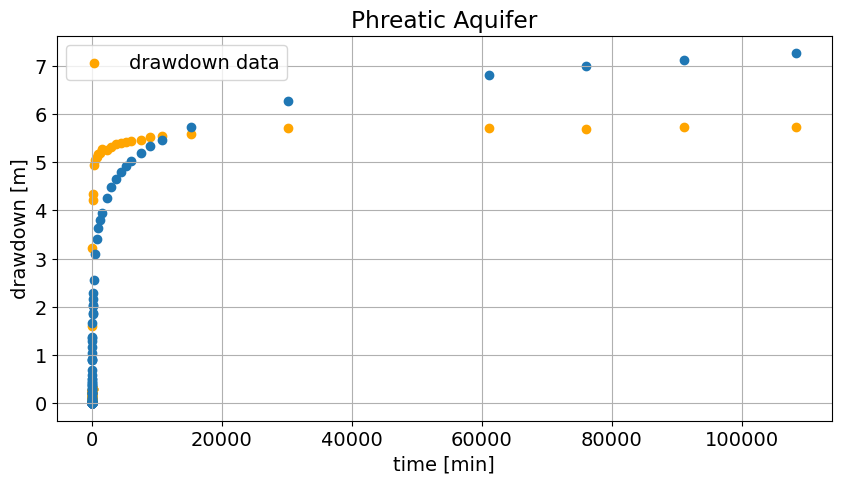

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
def Theis(r, params, x):
    storage, transmissivity = params
    etas = storage * r**2 / 4 / transmissivity / x
    return flowrate / 4 / np.pi / transmissivity * expintegral(etas, out=None)
params = [6.73,0.32]

ax.scatter(agg_times, agg_drawdowns, color= "orange", label="drawdown data")

ax.scatter(agg_times, Theis2(params,agg_times))
plt.xlabel('time [min]')
plt.ylabel(r"drawdown [m]")
plt.grid(True)
plt.title("Phreatic Aquifer")
plt.legend()
plt.show()

In [212]:
def MCMCbayesianfit(times, drawdowns, flowrate, r, input_initial_guess):
    # Redefine the function to fit
    # Define the model
    def Theis(params, x):
        storage, transmissivity = params
        etas = storage * r**2 / 4 / transmissivity / x
        return flowrate / 4 / np.pi / transmissivity * expintegral(etas, out=None)

    # Define the log-likelihood function
    def log_likelihood(params, x, y):
        y_pred = Theis(params, x)
        residuals = y - y_pred
        chi_squared = np.sum((residuals)**2)
        return -0.5 * chi_squared

    # Define the log-prior function
    def log_prior(params):
        storage, transmissivity = params
        if 0.00000001 < storage < 100  and 0.0005 < transmissivity < 100  :
            return 0.0
        return -np.inf

    # Define the log-posterior function
    def log_posterior(params, x, y):
        lp = log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(params, x, y)

    # Set up the MCMC sampler
    nwalkers = 50
    ndim = 2  # Number of parameters in the model
    initial_guess = input_initial_guess  # Initial guess for parameters

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(times, drawdowns))

    # Run the MCMC sampler
    n_steps = 5000
    sampler.run_mcmc(initial_guess + 0.00001 * np.random.randn(nwalkers, ndim), n_steps, progress=True)

    flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

    figure = corner.corner(
        flat_samples,
        labels=[
            r"Storage Coefficient",
            r"Transmissivity",
        ],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_fmt=".7f",
        title_kwargs={"fontsize": 12},
    )
    plt.show()

100%|██████████| 5000/5000 [00:11<00:00, 421.77it/s]


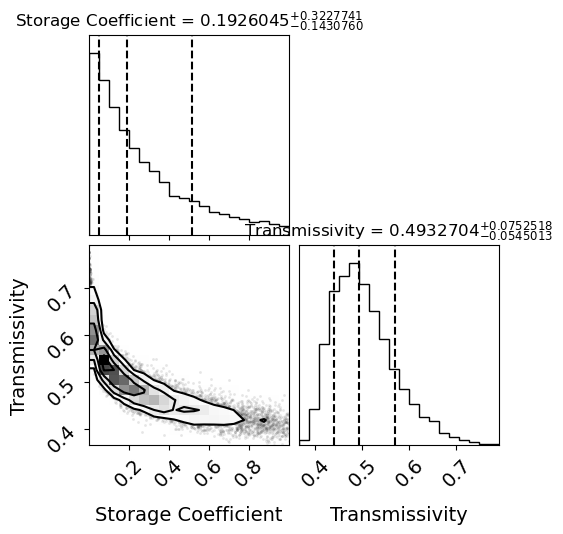

In [201]:
MCMCbayesianfit(times[1:], well[1:], flowrate, rs[0], [0.00001,0.1])

  1%|          | 34/5000 [00:00<00:14, 339.95it/s]

100%|██████████| 5000/5000 [00:11<00:00, 442.45it/s]


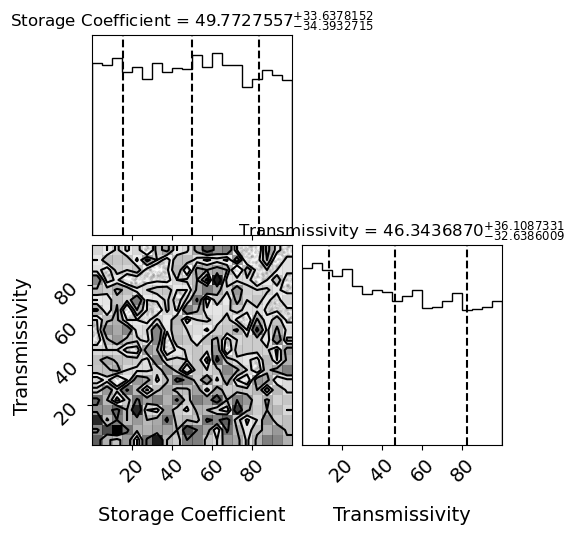

In [213]:
MCMCbayesianfit(times[1:], PZ1[1:], flowrate, rs[1], [0.01,0.1])

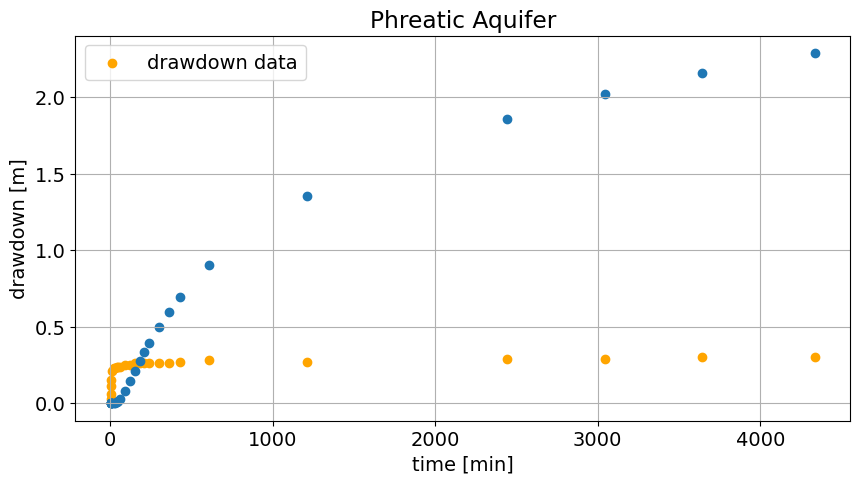

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
def Theis(r, params, x):
    storage, transmissivity = params
    etas = storage * r**2 / 4 / transmissivity / x
    return flowrate / 4 / np.pi / transmissivity * expintegral(etas, out=None)
params = [6.73,0.32]

ax.scatter(times[1:], PZ1[1:], color= "orange", label="drawdown data")

ax.scatter(times[1:], Theis(rs[1],params,times[1:]))
plt.xlabel('time [min]')
plt.ylabel(r"drawdown [m]")
plt.grid(True)
plt.title("Phreatic Aquifer")
plt.legend()
plt.show()